### Baseline Model : Tiny-ConvNext Fine-Tuned on Cifar-100

In [ ]:
import os
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

import torchvision
import torchvision.transforms as T
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights


# ----------------------------
# 1) Gated MHSA block
# ----------------------------
class GatedMHSA(nn.Module):
    """
    Input:  x (B, C, H, W)
    Output: x + alpha * MHSA(LN(x))
    where MHSA runs over spatial tokens (H*W).
    alpha is learnable and initialized at 0.
    """
    def __init__(self, channels: int, num_heads: int = 1, attn_dropout: float = 0.0):
        super().__init__()
        self.ln = nn.LayerNorm(channels)
        self.mha = nn.MultiheadAttention(
            embed_dim=channels,
            num_heads=num_heads,
            dropout=attn_dropout,
            batch_first=True
        )
        self.alpha = nn.Parameter(torch.zeros(1))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, c, h, w = x.shape
        tokens = x.permute(0, 2, 3, 1).reshape(b, h * w, c)     # (B, L, C)
        tokens_ln = self.ln(tokens)
        attn_out, _ = self.mha(tokens_ln, tokens_ln, tokens_ln, need_weights=False)
        attn_out = attn_out.reshape(b, h, w, c).permute(0, 3, 1, 2)  # (B, C, H, W)
        return x + self.alpha * attn_out


# ----------------------------
# 2) ConvNeXt-Tiny + dual attention (P2 + P3)
# ----------------------------
class ConvNeXtTiny_WithAttnP2P3(nn.Module):
    """
    TorchVision ConvNeXt-Tiny typically has:
      features = [0 stem, 1 stage1, 2 down1, 3 stage2, 4 down2, 5 stage3, 6 down3, 7 stage4]
    Channels: stage1=96, stage2=192, stage3=384, stage4=768

    Insert:
      - attn_p2 after stage2 (C=192) => after features[3]
      - attn_p3 after stage3 (C=384) => after features[5]
    """
    def __init__(self, num_classes: int = 100, num_heads_p2: int = 1, num_heads_p3: int = 1, pretrained: bool = True):
        super().__init__()
        weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1 if pretrained else None
        self.backbone = convnext_tiny(weights=weights)

        self.attn_p2 = GatedMHSA(channels=192, num_heads=num_heads_p2)
        self.attn_p3 = GatedMHSA(channels=384, num_heads=num_heads_p3)

        # Replace classifier head
        in_features = self.backbone.classifier[-1].in_features
        self.backbone.classifier[-1] = nn.Linear(in_features, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        f = self.backbone.features

        x = f[0](x)  # stem
        x = f[1](x)  # stage1 (C=96)
        x = f[2](x)  # down1
        x = f[3](x)  # stage2 (C=192)
        x = self.attn_p2(x)

        x = f[4](x)  # down2
        x = f[5](x)  # stage3 (C=384)
        x = self.attn_p3(x)

        x = f[6](x)  # down3
        x = f[7](x)  # stage4 (C=768)

        x = self.backbone.avgpool(x)
        x = self.backbone.classifier(x)
        return x


# ----------------------------
# 3) Config
# ----------------------------
@dataclass
class TrainConfig:
    data_root: str = "./data"
    out_dir: str = "./checkpoints_best_arch"

    num_classes: int = 100
    batch_size: int = 128
    num_workers: int = 2
    val_ratio: float = 0.1

    epochs: int = 20
    freeze_epochs: int = 5  # phase 1: freeze backbone

    lr_backbone: float = 1e-4
    lr_head: float = 5e-4
    weight_decay: float = 0.05

    seed: int = 42


def set_seed(seed: int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    import random, numpy as np
    random.seed(seed)
    np.random.seed(seed)


def set_requires_grad(module: nn.Module, flag: bool):
    for p in module.parameters():
        p.requires_grad = flag


# ----------------------------
# 4) Data loaders (train/val use different transforms correctly)
# ----------------------------
def build_loaders(cfg: TrainConfig):
    # CIFAR-100 mean/std
    mean = (0.5071, 0.4867, 0.4408)
    std  = (0.2675, 0.2565, 0.2761)

    train_tfms = T.Compose([
        T.RandomCrop(32, padding=4),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean, std),
    ])
    test_tfms = T.Compose([
        T.ToTensor(),
        T.Normalize(mean, std),
    ])

    # Two copies so val doesn't inherit train augmentation
    full_train_for_train = torchvision.datasets.CIFAR100(cfg.data_root, train=True, download=True, transform=train_tfms)
    full_train_for_val   = torchvision.datasets.CIFAR100(cfg.data_root, train=True, download=True, transform=test_tfms)
    test_set             = torchvision.datasets.CIFAR100(cfg.data_root, train=False, download=True, transform=test_tfms)

    n = len(full_train_for_train)
    val_size = int(n * cfg.val_ratio)
    train_size = n - val_size

    g = torch.Generator().manual_seed(cfg.seed)
    perm = torch.randperm(n, generator=g).tolist()
    train_idx = perm[:train_size]
    val_idx   = perm[train_size:]

    train_set = Subset(full_train_for_train, train_idx)
    val_set   = Subset(full_train_for_val, val_idx)

    train_loader = DataLoader(train_set, batch_size=cfg.batch_size, shuffle=True,
                              num_workers=cfg.num_workers, pin_memory=True)
    val_loader = DataLoader(val_set, batch_size=cfg.batch_size, shuffle=False,
                            num_workers=cfg.num_workers, pin_memory=True)
    test_loader = DataLoader(test_set, batch_size=cfg.batch_size, shuffle=False,
                             num_workers=cfg.num_workers, pin_memory=True)
    return train_loader, val_loader, test_loader


# ----------------------------
# 5) Optimizer (FIXED: no parameter overlap)
# ----------------------------
def make_optimizer(model: ConvNeXtTiny_WithAttnP2P3, cfg: TrainConfig):
    # Head group: attention blocks + classifier
    head_params = []
    head_ids = set()

    for p in model.attn_p2.parameters():
        if p.requires_grad:
            head_params.append(p)
            head_ids.add(id(p))

    for p in model.attn_p3.parameters():
        if p.requires_grad:
            head_params.append(p)
            head_ids.add(id(p))

    for p in model.backbone.classifier.parameters():
        if p.requires_grad:
            head_params.append(p)
            head_ids.add(id(p))

    # Backbone group: everything else in backbone, excluding head params
    backbone_params = []
    for p in model.backbone.parameters():
        if p.requires_grad and (id(p) not in head_ids):
            backbone_params.append(p)

    return optim.AdamW(
        [
            {"params": backbone_params, "lr": cfg.lr_backbone},
            {"params": head_params, "lr": cfg.lr_head},
        ],
        weight_decay=cfg.weight_decay
    )


def make_scheduler(optimizer, cfg: TrainConfig):
    return optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs)


# ----------------------------
# 6) Train / Eval
# ----------------------------
@torch.no_grad()
def evaluate_acc(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return correct / max(1, total)


def train_one_epoch(model, loader, optimizer, device, use_amp: bool):
    model.train()
    loss_fn = nn.CrossEntropyLoss()

    is_cuda = device.type == "cuda"
    scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and is_cuda))

    total_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)

        if use_amp and is_cuda:
            with torch.autocast(device_type="cuda", dtype=torch.float16):
                logits = model(x)
                loss = loss_fn(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()

        bs = y.size(0)
        total_loss += loss.item() * bs
        correct += (logits.argmax(1) == y).sum().item()
        total += bs

    return total_loss / max(1, total), correct / max(1, total)


# ----------------------------
# 7) Main
# ----------------------------
def main():
    cfg = TrainConfig()
    set_seed(cfg.seed)
    os.makedirs(cfg.out_dir, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    use_amp = torch.cuda.is_available()

    train_loader, val_loader, test_loader = build_loaders(cfg)

    # BEST tried architecture (non-baseline):
    # dual attention at P2+P3, 1 head each
    model = ConvNeXtTiny_WithAttnP2P3(
        num_classes=cfg.num_classes,
        num_heads_p2=1,
        num_heads_p3=1,
        pretrained=True
    ).to(device)

    # Phase 1: freeze backbone; train attention + classifier
    set_requires_grad(model.backbone, False)
    set_requires_grad(model.attn_p2, True)
    set_requires_grad(model.attn_p3, True)
    set_requires_grad(model.backbone.classifier, True)

    optimizer = make_optimizer(model, cfg)
    scheduler = make_scheduler(optimizer, cfg)

    best_val = -1.0
    best_path = os.path.join(cfg.out_dir, "best.pth")

    for epoch in range(cfg.epochs):
        # Phase 2: unfreeze full backbone at epoch == freeze_epochs
        if epoch == cfg.freeze_epochs:
            set_requires_grad(model.backbone, True)
            # rebuild optimizer + scheduler so newly-trainable params are included correctly
            optimizer = make_optimizer(model, cfg)
            scheduler = make_scheduler(optimizer, cfg)

        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device, use_amp=use_amp)
        val_acc = evaluate_acc(model, val_loader, device)
        scheduler.step()

        print(
            f"Epoch {epoch+1:02d}/{cfg.epochs} | "
            f"train loss {train_loss:.4f} | train acc {train_acc*100:.2f}% | "
            f"val acc {val_acc*100:.2f}% | "
            f"alpha_p2 {model.attn_p2.alpha.item():+.4f} | alpha_p3 {model.attn_p3.alpha.item():+.4f}"
        )

        if val_acc > best_val:
            best_val = val_acc
            torch.save(
                {
                    "epoch": epoch + 1,
                    "val_acc": best_val,
                    "model_state": model.state_dict(),
                    "cfg": cfg.__dict__,
                },
                best_path
            )

    # Evaluate best on test
    ckpt = torch.load(best_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    test_acc = evaluate_acc(model, test_loader, device)

    print("\nDone.")
    print(f"Best val acc: {ckpt['val_acc']*100:.2f}% at epoch {ckpt['epoch']}")
    print(f"Test acc (best ckpt): {test_acc*100:.2f}%")
    print(f"Saved checkpoint: {best_path}")


if __name__ == "__main__":
    main()


/tmp/ipython-input-3810020242.py:234: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and is_cuda))


Epoch 01/20 | train loss 2.2595 | train acc 43.06% | val acc 57.62% | alpha_p2 +0.0469 | alpha_p3 -0.0949
Epoch 02/20 | train loss 1.4445 | train acc 58.64% | val acc 61.56% | alpha_p2 +0.0574 | alpha_p3 -0.1097
Epoch 03/20 | train loss 1.2925 | train acc 62.36% | val acc 64.24% | alpha_p2 +0.0634 | alpha_p3 -0.1157
Epoch 04/20 | train loss 1.2009 | train acc 64.81% | val acc 64.94% | alpha_p2 +0.0708 | alpha_p3 -0.1178
Epoch 05/20 | train loss 1.1467 | train acc 66.50% | val acc 65.72% | alpha_p2 +0.0744 | alpha_p3 -0.1262
Epoch 06/20 | train loss 1.0955 | train acc 67.62% | val acc 70.46% | alpha_p2 +0.0508 | alpha_p3 -0.1017
Epoch 07/20 | train loss 0.8383 | train acc 74.42% | val acc 71.64% | alpha_p2 +0.0418 | alpha_p3 -0.0893
Epoch 08/20 | train loss 0.6662 | train acc 79.74% | val acc 72.24% | alpha_p2 +0.0358 | alpha_p3 -0.0795
Epoch 09/20 | train loss 0.5226 | train acc 83.69% | val acc 73.14% | alpha_p2 +0.0330 | alpha_p3 -0.0733
Epoch 10/20 | train loss 0.4062 | train acc 87

### This model adds attention and a few architectural changes (strides, padding, label smoothing)

In [ ]:
import os
from dataclasses import dataclass
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

import torchvision
import torchvision.transforms as T
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights


# ----------------------------
# 1) Gated MHSA
# ----------------------------
class GatedMHSA(nn.Module):
    def __init__(self, channels: int, num_heads: int = 1, attn_dropout: float = 0.0):
        super().__init__()
        self.ln = nn.LayerNorm(channels)
        self.mha = nn.MultiheadAttention(
            embed_dim=channels,
            num_heads=num_heads,
            dropout=attn_dropout,
            batch_first=True
        )
        self.alpha = nn.Parameter(torch.zeros(1))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, c, h, w = x.shape
        tokens = x.permute(0, 2, 3, 1).reshape(b, h*w, c)  # (B,L,C)
        tokens = self.ln(tokens)
        attn_out, _ = self.mha(tokens, tokens, tokens, need_weights=False)
        attn_out = attn_out.reshape(b, h, w, c).permute(0, 3, 1, 2)  # (B,C,H,W)
        return x + self.alpha * attn_out


# ----------------------------
# 2) ConvNeXt-Tiny + Attn at P2+P3
# ----------------------------
class ConvNeXtTiny_WithAttnP2P3(nn.Module):
    def __init__(self, num_classes: int = 100, heads_p2: int = 1, heads_p3: int = 1, pretrained: bool = True):
        super().__init__()
        weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1 if pretrained else None
        self.backbone = convnext_tiny(weights=weights)

        self.attn_p2 = GatedMHSA(channels=192, num_heads=heads_p2)
        self.attn_p3 = GatedMHSA(channels=384, num_heads=heads_p3)

        in_features = self.backbone.classifier[-1].in_features
        self.backbone.classifier[-1] = nn.Linear(in_features, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        f = self.backbone.features
        x = f[0](x)      # stem
        x = f[1](x)      # stage1
        x = f[2](x)      # down1
        x = f[3](x)      # stage2
        x = self.attn_p2(x)
        x = f[4](x)      # down2
        x = f[5](x)      # stage3
        x = self.attn_p3(x)
        x = f[6](x)      # down3
        x = f[7](x)      # stage4
        x = self.backbone.avgpool(x)
        x = self.backbone.classifier(x)
        return x


# ----------------------------
# 3) Stem patch for CIFAR (stride 4->2, padding 0->1)
# ----------------------------
def patch_convnext_stem_for_cifar(model: ConvNeXtTiny_WithAttnP2P3):
    stem = model.backbone.features[0]
    conv = None
    for m in stem.modules():
        if isinstance(m, nn.Conv2d):
            conv = m
            break
    if conv is None:
        raise RuntimeError("Could not find Conv2d in stem.")
    conv.stride = (2, 2)
    conv.padding = (1, 1)


# ----------------------------
# 4) Config
# ----------------------------
@dataclass
class TrainConfig:
    data_root: str = "./data"
    out_dir: str = "./checkpoints_fair_best"

    num_classes: int = 100
    batch_size: int = 128
    num_workers: int = 2
    val_ratio: float = 0.1

    epochs: int = 20
    # IMPORTANT: with stem patch, don't freeze backbone
    freeze_epochs: int = 0   # set to 1 if you really want, but 0 is recommended

    lr_backbone: float = 1e-4
    lr_head: float = 5e-4
    weight_decay: float = 0.05

    label_smoothing: float = 0.1
    seed: int = 42


def set_seed(seed: int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)


def build_loaders(cfg: TrainConfig):
    mean = (0.5071, 0.4867, 0.4408)
    std  = (0.2675, 0.2565, 0.2761)

    train_tfms = T.Compose([
        T.RandomCrop(32, padding=4),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean, std),
    ])
    test_tfms = T.Compose([
        T.ToTensor(),
        T.Normalize(mean, std),
    ])

    train_ds = torchvision.datasets.CIFAR100(cfg.data_root, train=True, download=True, transform=train_tfms)
    val_ds   = torchvision.datasets.CIFAR100(cfg.data_root, train=True, download=True, transform=test_tfms)
    test_ds  = torchvision.datasets.CIFAR100(cfg.data_root, train=False, download=True, transform=test_tfms)

    n = len(train_ds)
    val_size = int(n * cfg.val_ratio)
    train_size = n - val_size

    g = torch.Generator().manual_seed(cfg.seed)
    perm = torch.randperm(n, generator=g).tolist()
    train_idx = perm[:train_size]
    val_idx = perm[train_size:]

    train_set = Subset(train_ds, train_idx)
    val_set   = Subset(val_ds, val_idx)

    train_loader = DataLoader(train_set, batch_size=cfg.batch_size, shuffle=True,
                              num_workers=cfg.num_workers, pin_memory=True)
    val_loader   = DataLoader(val_set, batch_size=cfg.batch_size, shuffle=False,
                              num_workers=cfg.num_workers, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False,
                              num_workers=cfg.num_workers, pin_memory=True)
    return train_loader, val_loader, test_loader


def make_optimizer(model: ConvNeXtTiny_WithAttnP2P3, cfg: TrainConfig):
    head_params = []
    head_ids = set()

    for p in model.attn_p2.parameters():
        head_params.append(p); head_ids.add(id(p))
    for p in model.attn_p3.parameters():
        head_params.append(p); head_ids.add(id(p))
    for p in model.backbone.classifier.parameters():
        head_params.append(p); head_ids.add(id(p))

    backbone_params = []
    for p in model.backbone.parameters():
        if id(p) not in head_ids:
            backbone_params.append(p)

    return optim.AdamW(
        [{"params": backbone_params, "lr": cfg.lr_backbone},
         {"params": head_params, "lr": cfg.lr_head}],
        weight_decay=cfg.weight_decay
    )


@torch.no_grad()
def eval_acc(model, loader, device):
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return correct / max(1, total)


def train_one_epoch(model, loader, optimizer, device, loss_fn, scaler):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)

        with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=(device.type == "cuda")):
            logits = model(x)
            loss = loss_fn(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bs = y.size(0)
        total_loss += loss.item() * bs
        correct += (logits.argmax(1) == y).sum().item()
        total += bs

    return total_loss / max(1, total), correct / max(1, total)


def main():
    cfg = TrainConfig()
    set_seed(cfg.seed)
    os.makedirs(cfg.out_dir, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    use_cuda = (device.type == "cuda")
    scaler = torch.amp.GradScaler("cuda", enabled=use_cuda)

    train_loader, val_loader, test_loader = build_loaders(cfg)

    model = ConvNeXtTiny_WithAttnP2P3(num_classes=cfg.num_classes, heads_p2=1, heads_p3=1, pretrained=True).to(device)

    # Apply CIFAR stem patch
    patch_convnext_stem_for_cifar(model)

    # Optionally freeze for 0-1 epochs only
    if cfg.freeze_epochs > 0:
        for p in model.backbone.parameters():
            p.requires_grad = False
        for p in model.attn_p2.parameters():
            p.requires_grad = True
        for p in model.attn_p3.parameters():
            p.requires_grad = True
        for p in model.backbone.classifier.parameters():
            p.requires_grad = True

    optimizer = make_optimizer(model, cfg)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs)

    loss_fn = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing)

    best_val = -1.0
    best_path = os.path.join(cfg.out_dir, "best.pth")

    for epoch in range(cfg.epochs):
        # Unfreeze after freeze phase
        if epoch == cfg.freeze_epochs and cfg.freeze_epochs > 0:
            for p in model.backbone.parameters():
                p.requires_grad = True
            optimizer = make_optimizer(model, cfg)  # rebuild to include backbone params

        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device, loss_fn, scaler)
        val_acc = eval_acc(model, val_loader, device)
        scheduler.step()

        print(
            f"Epoch {epoch+1:02d}/{cfg.epochs} | "
            f"train loss {train_loss:.4f} | train acc {train_acc*100:.2f}% | "
            f"val acc {val_acc*100:.2f}% | "
            f"alpha_p2 {model.attn_p2.alpha.item():+.4f} | alpha_p3 {model.attn_p3.alpha.item():+.4f}"
        )

        if val_acc > best_val:
            best_val = val_acc
            torch.save({"epoch": epoch+1, "val_acc": best_val, "model_state": model.state_dict()}, best_path)

    ckpt = torch.load(best_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    test_acc = eval_acc(model, test_loader, device)

    print("\nDone.")
    print(f"Best val acc: {ckpt['val_acc']*100:.2f}% at epoch {ckpt['epoch']}")
    print(f"Test acc (best ckpt): {test_acc*100:.2f}%")
    print(f"Saved checkpoint: {best_path}")


if __name__ == "__main__":
    main()



Epoch 01/20 | train loss 2.0234 | train acc 63.07% | val acc 79.26% | alpha_p2 +0.0005 | alpha_p3 +0.0230
Epoch 02/20 | train loss 1.2917 | train acc 82.75% | val acc 82.74% | alpha_p2 -0.0003 | alpha_p3 +0.0167
Epoch 03/20 | train loss 1.1440 | train acc 87.82% | val acc 83.68% | alpha_p2 +0.0018 | alpha_p3 +0.0179
Epoch 04/20 | train loss 1.0496 | train acc 91.02% | val acc 83.04% | alpha_p2 +0.0003 | alpha_p3 +0.0187
Epoch 05/20 | train loss 0.9827 | train acc 93.67% | val acc 83.88% | alpha_p2 +0.0015 | alpha_p3 +0.0167
Epoch 06/20 | train loss 0.9388 | train acc 95.22% | val acc 84.74% | alpha_p2 -0.0012 | alpha_p3 +0.0179
Epoch 07/20 | train loss 0.9079 | train acc 96.21% | val acc 84.16% | alpha_p2 +0.0019 | alpha_p3 +0.0147
Epoch 08/20 | train loss 0.8815 | train acc 97.20% | val acc 84.80% | alpha_p2 +0.0008 | alpha_p3 +0.0177
Epoch 09/20 | train loss 0.8642 | train acc 97.76% | val acc 84.84% | alpha_p2 -0.0005 | alpha_p3 +0.0176
Epoch 10/20 | train loss 0.8501 | train acc 98

### the model below does the same as the previous one but without the attention

In [ ]:
import os
from dataclasses import dataclass
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

import torchvision
import torchvision.transforms as T
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights


# ----------------------------
# 1) Baseline ConvNeXt-Tiny (NO attention)
# ----------------------------
class ConvNeXtTiny_Baseline(nn.Module):
    def __init__(self, num_classes: int = 100, pretrained: bool = True):
        super().__init__()
        weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1 if pretrained else None
        self.backbone = convnext_tiny(weights=weights)

        in_features = self.backbone.classifier[-1].in_features
        self.backbone.classifier[-1] = nn.Linear(in_features, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.backbone(x)


# ----------------------------
# 2) Stem patch for CIFAR (stride 4->2, padding 0->1)
#    (same as your attention run, to isolate attention effect)
# ----------------------------
def patch_convnext_stem_for_cifar(model):
    stem = model.backbone.features[0]
    conv = None
    for m in stem.modules():
        if isinstance(m, nn.Conv2d):
            conv = m
            break
    if conv is None:
        raise RuntimeError("Could not find Conv2d in stem.")
    conv.stride = (2, 2)
    conv.padding = (1, 1)


# ----------------------------
# 3) Config (same as your attention run)
# ----------------------------
@dataclass
class TrainConfig:
    data_root: str = "./data"
    out_dir: str = "./checkpoints_fair_best_baseline_no_attention"

    num_classes: int = 100
    batch_size: int = 128
    num_workers: int = 2
    val_ratio: float = 0.1

    epochs: int = 20
    freeze_epochs: int = 0  # keep identical to your attention run

    lr_backbone: float = 1e-4
    lr_head: float = 5e-4
    weight_decay: float = 0.05

    label_smoothing: float = 0.1
    seed: int = 42


def set_seed(seed: int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)


# ----------------------------
# 4) Data loaders (same split logic + same transforms)
# ----------------------------
def build_loaders(cfg: TrainConfig):
    mean = (0.5071, 0.4867, 0.4408)
    std  = (0.2675, 0.2565, 0.2761)

    train_tfms = T.Compose([
        T.RandomCrop(32, padding=4),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean, std),
    ])
    test_tfms = T.Compose([
        T.ToTensor(),
        T.Normalize(mean, std),
    ])

    train_ds = torchvision.datasets.CIFAR100(cfg.data_root, train=True, download=True, transform=train_tfms)
    val_ds   = torchvision.datasets.CIFAR100(cfg.data_root, train=True, download=True, transform=test_tfms)
    test_ds  = torchvision.datasets.CIFAR100(cfg.data_root, train=False, download=True, transform=test_tfms)

    n = len(train_ds)
    val_size = int(n * cfg.val_ratio)
    train_size = n - val_size

    g = torch.Generator().manual_seed(cfg.seed)
    perm = torch.randperm(n, generator=g).tolist()
    train_idx = perm[:train_size]
    val_idx = perm[train_size:]

    train_set = Subset(train_ds, train_idx)
    val_set   = Subset(val_ds, val_idx)

    train_loader = DataLoader(train_set, batch_size=cfg.batch_size, shuffle=True,
                              num_workers=cfg.num_workers, pin_memory=True)
    val_loader   = DataLoader(val_set, batch_size=cfg.batch_size, shuffle=False,
                              num_workers=cfg.num_workers, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False,
                              num_workers=cfg.num_workers, pin_memory=True)
    return train_loader, val_loader, test_loader


# ----------------------------
# 5) Optimizer (two param groups: backbone vs classifier head)
#    (mirrors your attention run: head LR higher)
# ----------------------------
def make_optimizer(model: ConvNeXtTiny_Baseline, cfg: TrainConfig):
    backbone_params = []
    head_params = []

    # classifier params as "head"
    head_ids = set(id(p) for p in model.backbone.classifier.parameters())
    for p in model.backbone.parameters():
        if id(p) in head_ids:
            head_params.append(p)
        else:
            backbone_params.append(p)

    return optim.AdamW(
        [{"params": backbone_params, "lr": cfg.lr_backbone},
         {"params": head_params, "lr": cfg.lr_head}],
        weight_decay=cfg.weight_decay
    )


@torch.no_grad()
def eval_acc(model, loader, device):
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return correct / max(1, total)


def train_one_epoch(model, loader, optimizer, device, loss_fn, scaler):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)

        with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=(device.type == "cuda")):
            logits = model(x)
            loss = loss_fn(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bs = y.size(0)
        total_loss += loss.item() * bs
        correct += (logits.argmax(1) == y).sum().item()
        total += bs

    return total_loss / max(1, total), correct / max(1, total)


def main():
    cfg = TrainConfig()
    set_seed(cfg.seed)
    os.makedirs(cfg.out_dir, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    use_cuda = (device.type == "cuda")
    scaler = torch.amp.GradScaler("cuda", enabled=use_cuda)

    train_loader, val_loader, test_loader = build_loaders(cfg)

    # Baseline model (NO attention)
    model = ConvNeXtTiny_Baseline(num_classes=cfg.num_classes, pretrained=True).to(device)

    # Apply the same CIFAR stem patch (so the ONLY difference vs your other run is attention)
    patch_convnext_stem_for_cifar(model)

    # Freeze policy kept identical (freeze_epochs=0 means do nothing)
    if cfg.freeze_epochs > 0:
        for p in model.backbone.parameters():
            p.requires_grad = False
        for p in model.backbone.classifier.parameters():
            p.requires_grad = True

    optimizer = make_optimizer(model, cfg)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs)

    loss_fn = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing)

    best_val = -1.0
    best_path = os.path.join(cfg.out_dir, "best.pth")

    for epoch in range(cfg.epochs):
        if epoch == cfg.freeze_epochs and cfg.freeze_epochs > 0:
            for p in model.backbone.parameters():
                p.requires_grad = True
            optimizer = make_optimizer(model, cfg)

        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device, loss_fn, scaler)
        val_acc = eval_acc(model, val_loader, device)
        scheduler.step()

        print(
            f"Epoch {epoch+1:02d}/{cfg.epochs} | "
            f"train loss {train_loss:.4f} | train acc {train_acc*100:.2f}% | "
            f"val acc {val_acc*100:.2f}%"
        )

        if val_acc > best_val:
            best_val = val_acc
            torch.save({"epoch": epoch+1, "val_acc": best_val, "model_state": model.state_dict()}, best_path)

    ckpt = torch.load(best_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    test_acc = eval_acc(model, test_loader, device)

    print("\nDone.")
    print(f"Best val acc: {ckpt['val_acc']*100:.2f}% at epoch {ckpt['epoch']}")
    print(f"Test acc (best ckpt): {test_acc*100:.2f}%")
    print(f"Saved checkpoint: {best_path}")


if __name__ == "__main__":
    main()


Epoch 01/20 | train loss 1.9881 | train acc 64.07% | val acc 79.14%
Epoch 02/20 | train loss 1.2873 | train acc 82.89% | val acc 81.90%
Epoch 03/20 | train loss 1.1407 | train acc 87.95% | val acc 82.72%
Epoch 04/20 | train loss 1.0485 | train acc 91.23% | val acc 83.82%
Epoch 05/20 | train loss 0.9861 | train acc 93.42% | val acc 83.76%
Epoch 06/20 | train loss 0.9411 | train acc 94.99% | val acc 84.42%
Epoch 07/20 | train loss 0.9076 | train acc 96.32% | val acc 83.90%
Epoch 08/20 | train loss 0.8834 | train acc 97.05% | val acc 84.62%
Epoch 09/20 | train loss 0.8664 | train acc 97.63% | val acc 84.80%
Epoch 10/20 | train loss 0.8509 | train acc 98.22% | val acc 84.88%
Epoch 11/20 | train loss 0.8446 | train acc 98.35% | val acc 84.74%
Epoch 12/20 | train loss 0.8328 | train acc 98.85% | val acc 85.02%
Epoch 13/20 | train loss 0.8255 | train acc 98.98% | val acc 85.24%
Epoch 14/20 | train loss 0.8180 | train acc 99.25% | val acc 85.56%
Epoch 15/20 | train loss 0.8151 | train acc 99.3

In [ ]:
import os
from dataclasses import dataclass
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

import torchvision
import torchvision.transforms as T
from torchvision.models import convnext_tiny


# ----------------------------
# 1) Baseline ConvNeXt-Tiny (NO attention) — TRAIN FROM SCRATCH
# ----------------------------
class ConvNeXtTiny_Baseline(nn.Module):
    def __init__(self, num_classes: int = 100):
        super().__init__()
        # IMPORTANT: pretrained=False => random init (retraining)
        self.backbone = convnext_tiny(weights=None)
        in_features = self.backbone.classifier[-1].in_features
        self.backbone.classifier[-1] = nn.Linear(in_features, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.backbone(x)


# ----------------------------
# 2) Optional: Stem patch for CIFAR (stride 4->2, padding 0->1)
#    Keep it ON/OFF consistently for both baseline and attention runs.
# ----------------------------
def patch_convnext_stem_for_cifar(model):
    stem = model.backbone.features[0]
    conv = None
    for m in stem.modules():
        if isinstance(m, nn.Conv2d):
            conv = m
            break
    if conv is None:
        raise RuntimeError("Could not find Conv2d in stem.")
    conv.stride = (2, 2)
    conv.padding = (1, 1)


# ----------------------------
# 3) Config — from-scratch friendly
# ----------------------------
@dataclass
class TrainConfig:
    data_root: str = "./data"
    out_dir: str = "./checkpoints_retrain_baseline"

    num_classes: int = 100
    batch_size: int = 128
    num_workers: int = 2
    val_ratio: float = 0.1

    # From scratch needs more than 20 epochs to be meaningful
    epochs: int = 100

    # Single LR is fine from scratch (no "protect pretrained backbone" needed)
    lr: float = 2e-3
    weight_decay: float = 0.05

    # Optional but usually helpful
    label_smoothing: float = 0.1

    # Toggle stem patch here (keep same value for attention experiment)
    use_stem_patch: bool = True

    seed: int = 42


def set_seed(seed: int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)


# ----------------------------
# 4) Data loaders (CIFAR-100)
# ----------------------------
def build_loaders(cfg: TrainConfig):
    mean = (0.5071, 0.4867, 0.4408)
    std  = (0.2675, 0.2565, 0.2761)

    train_tfms = T.Compose([
        T.RandomCrop(32, padding=4),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean, std),
    ])
    test_tfms = T.Compose([
        T.ToTensor(),
        T.Normalize(mean, std),
    ])

    train_ds = torchvision.datasets.CIFAR100(cfg.data_root, train=True, download=True, transform=train_tfms)
    val_ds   = torchvision.datasets.CIFAR100(cfg.data_root, train=True, download=True, transform=test_tfms)
    test_ds  = torchvision.datasets.CIFAR100(cfg.data_root, train=False, download=True, transform=test_tfms)

    n = len(train_ds)
    val_size = int(n * cfg.val_ratio)
    train_size = n - val_size

    g = torch.Generator().manual_seed(cfg.seed)
    perm = torch.randperm(n, generator=g).tolist()
    train_idx = perm[:train_size]
    val_idx = perm[train_size:]

    # Sanity: ensure no overlap
    assert len(set(train_idx).intersection(set(val_idx))) == 0

    train_set = Subset(train_ds, train_idx)
    val_set   = Subset(val_ds, val_idx)

    train_loader = DataLoader(train_set, batch_size=cfg.batch_size, shuffle=True,
                              num_workers=cfg.num_workers, pin_memory=True)
    val_loader   = DataLoader(val_set, batch_size=cfg.batch_size, shuffle=False,
                              num_workers=cfg.num_workers, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False,
                              num_workers=cfg.num_workers, pin_memory=True)
    return train_loader, val_loader, test_loader


# ----------------------------
# 5) Train/Eval
# ----------------------------
@torch.no_grad()
def eval_acc(model, loader, device):
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return correct / max(1, total)


def train_one_epoch(model, loader, optimizer, device, loss_fn, scaler):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)

        with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=(device.type == "cuda")):
            logits = model(x)
            loss = loss_fn(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bs = y.size(0)
        total_loss += loss.item() * bs
        correct += (logits.argmax(1) == y).sum().item()
        total += bs

    return total_loss / max(1, total), correct / max(1, total)


def main():
    cfg = TrainConfig()
    set_seed(cfg.seed)
    os.makedirs(cfg.out_dir, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    scaler = torch.amp.GradScaler("cuda", enabled=(device.type == "cuda"))

    train_loader, val_loader, test_loader = build_loaders(cfg)

    model = ConvNeXtTiny_Baseline(num_classes=cfg.num_classes).to(device)

    if cfg.use_stem_patch:
        patch_convnext_stem_for_cifar(model)

    optimizer = optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs)

    loss_fn = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing)

    best_val = -1.0
    best_path = os.path.join(cfg.out_dir, "best.pth")

    print(
        f"Training from scratch on CIFAR-100 | "
        f"stem_patch={cfg.use_stem_patch} | "
        f"epochs={cfg.epochs} | lr={cfg.lr}"
    )

    for epoch in range(cfg.epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device, loss_fn, scaler)
        val_acc = eval_acc(model, val_loader, device)
        scheduler.step()

        print(
            f"Epoch {epoch+1:03d}/{cfg.epochs} | "
            f"train loss {train_loss:.4f} | train acc {train_acc*100:.2f}% | "
            f"val acc {val_acc*100:.2f}%"
        )

        if val_acc > best_val:
            best_val = val_acc
            torch.save({"epoch": epoch+1, "val_acc": best_val, "model_state": model.state_dict()}, best_path)

    ckpt = torch.load(best_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    test_acc = eval_acc(model, test_loader, device)

    print("\nDone.")
    print(f"Best val acc: {ckpt['val_acc']*100:.2f}% at epoch {ckpt['epoch']}")
    print(f"Test acc (best ckpt): {test_acc*100:.2f}%")
    print(f"Saved checkpoint: {best_path}")


if __name__ == "__main__":
    main()


100%|██████████| 169M/169M [00:05<00:00, 29.5MB/s]


Training from scratch on CIFAR-100 | stem_patch=True | epochs=100 | lr=0.002
Epoch 001/100 | train loss 4.2143 | train acc 7.41% | val acc 12.78%
Epoch 002/100 | train loss 3.8331 | train acc 13.63% | val acc 17.46%
Epoch 003/100 | train loss 3.6146 | train acc 18.39% | val acc 22.46%
Epoch 004/100 | train loss 3.4484 | train acc 21.98% | val acc 25.48%
Epoch 005/100 | train loss 3.3277 | train acc 25.04% | val acc 27.12%
Epoch 006/100 | train loss 3.1937 | train acc 27.99% | val acc 30.94%
Epoch 007/100 | train loss 3.0679 | train acc 31.24% | val acc 33.44%
Epoch 008/100 | train loss 2.9569 | train acc 34.28% | val acc 36.74%
Epoch 009/100 | train loss 2.8544 | train acc 36.74% | val acc 38.92%
Epoch 010/100 | train loss 2.7398 | train acc 39.94% | val acc 40.78%
Epoch 011/100 | train loss 2.6303 | train acc 42.61% | val acc 41.86%
Epoch 012/100 | train loss 2.5257 | train acc 45.70% | val acc 44.32%
Epoch 013/100 | train loss 2.4357 | train acc 47.84% | val acc 45.24%
Epoch 014/100 

KeyboardInterrupt: 

In [ ]:
import os
from dataclasses import dataclass
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

import torchvision
import torchvision.transforms as T
from torchvision.models import convnext_tiny


# ----------------------------
# 1) Gated MHSA (same idea as before)
# ----------------------------
class GatedMHSA(nn.Module):
    def __init__(self, channels: int, num_heads: int = 1, attn_dropout: float = 0.0):
        super().__init__()
        self.ln = nn.LayerNorm(channels)
        self.mha = nn.MultiheadAttention(
            embed_dim=channels,
            num_heads=num_heads,
            dropout=attn_dropout,
            batch_first=True
        )
        # gate starts at 0 => attention path starts "off" and can be learned on
        self.alpha = nn.Parameter(torch.zeros(1))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, c, h, w = x.shape
        tokens = x.permute(0, 2, 3, 1).reshape(b, h * w, c)  # (B, L, C)
        tokens = self.ln(tokens)
        attn_out, _ = self.mha(tokens, tokens, tokens, need_weights=False)
        attn_out = attn_out.reshape(b, h, w, c).permute(0, 3, 1, 2)  # (B, C, H, W)
        return x + self.alpha * attn_out


# ----------------------------
# 2) ConvNeXt-Tiny + Attn at P2 and P3 (TRAIN FROM SCRATCH)
# ----------------------------
class ConvNeXtTiny_WithAttnP2P3(nn.Module):
    def __init__(self, num_classes: int = 100, heads_p2: int = 1, heads_p3: int = 1):
        super().__init__()
        # IMPORTANT: weights=None => random init (retraining)
        self.backbone = convnext_tiny(weights=None)

        # P2 channel dim = 192, P3 channel dim = 384 in convnext_tiny
        self.attn_p2 = GatedMHSA(channels=192, num_heads=heads_p2)
        self.attn_p3 = GatedMHSA(channels=384, num_heads=heads_p3)

        in_features = self.backbone.classifier[-1].in_features
        self.backbone.classifier[-1] = nn.Linear(in_features, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        f = self.backbone.features
        x = f[0](x)      # stem
        x = f[1](x)      # stage1
        x = f[2](x)      # down1
        x = f[3](x)      # stage2
        x = self.attn_p2(x)
        x = f[4](x)      # down2
        x = f[5](x)      # stage3
        x = self.attn_p3(x)
        x = f[6](x)      # down3
        x = f[7](x)      # stage4
        x = self.backbone.avgpool(x)
        x = self.backbone.classifier(x)
        return x


# ----------------------------
# 3) Optional: Stem patch for CIFAR (stride 4->2, padding 0->1)
#    Keep identical to baseline for fair comparison.
# ----------------------------
def patch_convnext_stem_for_cifar(model):
    stem = model.backbone.features[0]
    conv = None
    for m in stem.modules():
        if isinstance(m, nn.Conv2d):
            conv = m
            break
    if conv is None:
        raise RuntimeError("Could not find Conv2d in stem.")
    conv.stride = (2, 2)
    conv.padding = (1, 1)


# ----------------------------
# 4) Config (match your from-scratch baseline)
# ----------------------------
@dataclass
class TrainConfig:
    data_root: str = "./data"
    out_dir: str = "./checkpoints_retrain_attention"

    num_classes: int = 100
    batch_size: int = 128
    num_workers: int = 2
    val_ratio: float = 0.1

    # Set to the SAME budget you will use for baseline (e.g., 50 or 70)
    epochs: int = 50

    lr: float = 2e-3
    weight_decay: float = 0.05
    label_smoothing: float = 0.1

    use_stem_patch: bool = True

    heads_p2: int = 1
    heads_p3: int = 1

    seed: int = 42


def set_seed(seed: int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)


def build_loaders(cfg: TrainConfig):
    mean = (0.5071, 0.4867, 0.4408)
    std  = (0.2675, 0.2565, 0.2761)

    train_tfms = T.Compose([
        T.RandomCrop(32, padding=4),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean, std),
    ])
    test_tfms = T.Compose([
        T.ToTensor(),
        T.Normalize(mean, std),
    ])

    train_ds = torchvision.datasets.CIFAR100(cfg.data_root, train=True, download=True, transform=train_tfms)
    val_ds   = torchvision.datasets.CIFAR100(cfg.data_root, train=True, download=True, transform=test_tfms)
    test_ds  = torchvision.datasets.CIFAR100(cfg.data_root, train=False, download=True, transform=test_tfms)

    n = len(train_ds)
    val_size = int(n * cfg.val_ratio)
    train_size = n - val_size

    g = torch.Generator().manual_seed(cfg.seed)
    perm = torch.randperm(n, generator=g).tolist()
    train_idx = perm[:train_size]
    val_idx = perm[train_size:]

    assert len(set(train_idx).intersection(set(val_idx))) == 0

    train_set = Subset(train_ds, train_idx)
    val_set   = Subset(val_ds, val_idx)

    train_loader = DataLoader(train_set, batch_size=cfg.batch_size, shuffle=True,
                              num_workers=cfg.num_workers, pin_memory=True)
    val_loader   = DataLoader(val_set, batch_size=cfg.batch_size, shuffle=False,
                              num_workers=cfg.num_workers, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False,
                              num_workers=cfg.num_workers, pin_memory=True)
    return train_loader, val_loader, test_loader


@torch.no_grad()
def eval_acc(model, loader, device):
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return correct / max(1, total)


def train_one_epoch(model, loader, optimizer, device, loss_fn, scaler):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)

        with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=(device.type == "cuda")):
            logits = model(x)
            loss = loss_fn(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bs = y.size(0)
        total_loss += loss.item() * bs
        correct += (logits.argmax(1) == y).sum().item()
        total += bs

    return total_loss / max(1, total), correct / max(1, total)


def main():
    cfg = TrainConfig()
    set_seed(cfg.seed)
    os.makedirs(cfg.out_dir, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    scaler = torch.amp.GradScaler("cuda", enabled=(device.type == "cuda"))

    train_loader, val_loader, test_loader = build_loaders(cfg)

    model = ConvNeXtTiny_WithAttnP2P3(
        num_classes=cfg.num_classes,
        heads_p2=cfg.heads_p2,
        heads_p3=cfg.heads_p3
    ).to(device)

    if cfg.use_stem_patch:
        patch_convnext_stem_for_cifar(model)

    optimizer = optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs)
    loss_fn = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing)

    best_val = -1.0
    best_path = os.path.join(cfg.out_dir, "best.pth")

    print(
        f"Training from scratch on CIFAR-100 | "
        f"stem_patch={cfg.use_stem_patch} | epochs={cfg.epochs} | lr={cfg.lr} | "
        f"attn=P2({cfg.heads_p2}h)+P3({cfg.heads_p3}h)"
    )

    for epoch in range(cfg.epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device, loss_fn, scaler)
        val_acc = eval_acc(model, val_loader, device)
        scheduler.step()

        print(
            f"Epoch {epoch+1:03d}/{cfg.epochs} | "
            f"train loss {train_loss:.4f} | train acc {train_acc*100:.2f}% | "
            f"val acc {val_acc*100:.2f}% | "
            f"alpha_p2 {model.attn_p2.alpha.item():+.4f} | alpha_p3 {model.attn_p3.alpha.item():+.4f}"
        )

        if val_acc > best_val:
            best_val = val_acc
            torch.save(
                {"epoch": epoch+1, "val_acc": best_val, "model_state": model.state_dict()},
                best_path
            )

    ckpt = torch.load(best_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    test_acc = eval_acc(model, test_loader, device)

    print("\nDone.")
    print(f"Best val acc: {ckpt['val_acc']*100:.2f}% at epoch {ckpt['epoch']}")
    print(f"Test acc (best ckpt): {test_acc*100:.2f}%")
    print(f"Saved checkpoint: {best_path}")


if __name__ == "__main__":
    main()


Training from scratch on CIFAR-100 | stem_patch=True | epochs=50 | lr=0.002 | attn=P2(1h)+P3(1h)
Epoch 001/50 | train loss 4.2292 | train acc 7.53% | val acc 13.00% | alpha_p2 +0.0013 | alpha_p3 -0.0231
Epoch 002/50 | train loss 3.8750 | train acc 13.00% | val acc 17.38% | alpha_p2 -0.0212 | alpha_p3 -0.0215
Epoch 003/50 | train loss 3.6953 | train acc 16.81% | val acc 18.38% | alpha_p2 +0.0013 | alpha_p3 -0.0248
Epoch 004/50 | train loss 3.5658 | train acc 19.36% | val acc 22.64% | alpha_p2 +0.0023 | alpha_p3 -0.0247
Epoch 005/50 | train loss 3.4693 | train acc 21.72% | val acc 24.26% | alpha_p2 -0.0114 | alpha_p3 -0.0218
Epoch 006/50 | train loss 3.3761 | train acc 24.13% | val acc 27.34% | alpha_p2 -0.0045 | alpha_p3 -0.0221
Epoch 007/50 | train loss 3.3000 | train acc 26.10% | val acc 27.76% | alpha_p2 -0.0135 | alpha_p3 -0.0255
Epoch 008/50 | train loss 3.2096 | train acc 28.13% | val acc 29.32% | alpha_p2 -0.0078 | alpha_p3 -0.0275
Epoch 009/50 | train loss 3.1304 | train acc 29.

# Disentangling Data vs Architecture: ViT and MLP-Mixer on CIFAR-100

### We compare an attention-native model (ViT) and a non-attention token-mixing model (MLP-Mixer) under the same training budget to test whether attention should help on CIFAR-100.

In [ ]:
import os
import random
from dataclasses import dataclass
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

import torchvision
import torchvision.transforms as T


def set_seed(seed: int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)


def build_cifar100_loaders(data_root: str, batch_size: int, num_workers: int, val_ratio: float, seed: int):
    # CIFAR-100 normalization (standard)
    mean = (0.5071, 0.4867, 0.4408)
    std  = (0.2675, 0.2565, 0.2761)

    train_tfms = T.Compose([
        T.RandomCrop(32, padding=4),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean, std),
    ])
    test_tfms = T.Compose([
        T.ToTensor(),
        T.Normalize(mean, std),
    ])

    train_ds = torchvision.datasets.CIFAR100(data_root, train=True, download=True, transform=train_tfms)
    val_ds   = torchvision.datasets.CIFAR100(data_root, train=True, download=True, transform=test_tfms)
    test_ds  = torchvision.datasets.CIFAR100(data_root, train=False, download=True, transform=test_tfms)

    n = len(train_ds)
    val_size = int(n * val_ratio)
    train_size = n - val_size

    g = torch.Generator().manual_seed(seed)
    perm = torch.randperm(n, generator=g).tolist()
    train_idx = perm[:train_size]
    val_idx = perm[train_size:]

    train_set = Subset(train_ds, train_idx)
    val_set   = Subset(val_ds, val_idx)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True)
    val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader, test_loader


@torch.no_grad()
def eval_acc(model, loader, device):
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        correct += (logits.argmax(1) == y).sum().item()
        total += y.size(0)
    return correct / max(1, total)


def train_one_epoch(model, loader, optimizer, device, loss_fn, scaler):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)

        with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=(device.type == "cuda")):
            logits = model(x)
            loss = loss_fn(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bs = y.size(0)
        total_loss += loss.item() * bs
        correct += (logits.argmax(1) == y).sum().item()
        total += bs

    return total_loss / max(1, total), correct / max(1, total)


@dataclass
class BaseCFG:
    # Data / run
    data_root: str = "./data"
    batch_size: int = 128
    num_workers: int = 2
    val_ratio: float = 0.1
    seed: int = 42

    # Training budget (match your ConvNeXt scratch runs)
    epochs: int = 50
    lr: float = 2e-3
    weight_decay: float = 0.05
    label_smoothing: float = 0.1

    # Task
    num_classes: int = 100  # CIFAR-100


In [ ]:
# ----------------------------
# ViT-Tiny for CIFAR-100 (from scratch)
# ----------------------------

class PatchEmbed(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=192):
        super().__init__()
        assert img_size % patch_size == 0
        self.grid = img_size // patch_size
        self.num_patches = self.grid * self.grid
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)                  # (B, C, H', W')
        x = x.flatten(2).transpose(1, 2)  # (B, N, C)
        return x


class MLP(nn.Module):
    def __init__(self, dim, hidden_dim, drop=0.0):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, dim)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.drop(self.act(self.fc1(x)))
        x = self.drop(self.fc2(x))
        return x


class ViTBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, attn_drop=0.0, drop=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=attn_drop, batch_first=True)
        self.drop1 = nn.Dropout(drop)

        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim * mlp_ratio), drop=drop)

    def forward(self, x):
        h = self.norm1(x)
        attn_out, _ = self.attn(h, h, h, need_weights=False)
        x = x + self.drop1(attn_out)
        x = x + self.mlp(self.norm2(x))
        return x


class ViTTiny(nn.Module):
    def __init__(self, num_classes=100, img_size=32, patch_size=4, embed_dim=192,
                 depth=12, num_heads=3, mlp_ratio=4.0, drop=0.0, attn_drop=0.0):
        super().__init__()
        self.patch = PatchEmbed(img_size, patch_size, 3, embed_dim)
        N = self.patch.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos = nn.Parameter(torch.zeros(1, 1 + N, embed_dim))
        self.pos_drop = nn.Dropout(drop)

        self.blocks = nn.ModuleList([
            ViTBlock(embed_dim, num_heads, mlp_ratio, attn_drop, drop)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        nn.init.trunc_normal_(self.pos, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        x = self.patch(x)  # (B, N, C)
        B, N, C = x.shape
        cls = self.cls_token.expand(B, -1, -1)  # (B,1,C)
        x = torch.cat([cls, x], dim=1)          # (B,1+N,C)
        x = self.pos_drop(x + self.pos)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return self.head(x[:, 0])  # CLS token


def run_vit():
    cfg = BaseCFG()
    out_dir = "./checkpoints_cifar100_vit_tiny_scratch"
    os.makedirs(out_dir, exist_ok=True)

    set_seed(cfg.seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    scaler = torch.amp.GradScaler("cuda", enabled=(device.type == "cuda"))

    train_loader, val_loader, test_loader = build_cifar100_loaders(
        cfg.data_root, cfg.batch_size, cfg.num_workers, cfg.val_ratio, cfg.seed
    )

    model = ViTTiny(
        num_classes=cfg.num_classes,
        img_size=32,
        patch_size=4,
        embed_dim=192,
        depth=12,
        num_heads=3,
        mlp_ratio=4.0,
        drop=0.0,
        attn_drop=0.0,
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs)
    loss_fn = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing)

    best_val = -1.0
    best_path = os.path.join(out_dir, "best.pth")

    print(f"ViT-Tiny (scratch) on CIFAR-100 | epochs={cfg.epochs} | lr={cfg.lr}")

    for epoch in range(cfg.epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device, loss_fn, scaler)
        val_acc = eval_acc(model, val_loader, device)
        scheduler.step()

        print(
            f"Epoch {epoch+1:03d}/{cfg.epochs} | "
            f"train loss {train_loss:.4f} | train acc {train_acc*100:.2f}% | "
            f"val acc {val_acc*100:.2f}%"
        )

        if val_acc > best_val:
            best_val = val_acc
            torch.save({"epoch": epoch+1, "val_acc": best_val, "model_state": model.state_dict()}, best_path)

    ckpt = torch.load(best_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    test_acc = eval_acc(model, test_loader, device)

    print("\nDone.")
    print(f"Best val acc: {ckpt['val_acc']*100:.2f}% at epoch {ckpt['epoch']}")
    print(f"Test acc (best ckpt): {test_acc*100:.2f}%")
    print(f"Saved checkpoint: {best_path}")


run_vit()


ViT-Tiny (scratch) on CIFAR-100 | epochs=50 | lr=0.002


KeyboardInterrupt: 

### we got ~ 41% accuracy here

In [ ]:
# ----------------------------
# MLP-Mixer-Tiny for CIFAR-100 (from scratch)
# ----------------------------

class PatchEmbed(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=192):
        super().__init__()
        assert img_size % patch_size == 0
        self.grid = img_size // patch_size
        self.num_patches = self.grid * self.grid
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)                  # (B, C, H', W')
        x = x.flatten(2).transpose(1, 2)  # (B, N, C)
        return x


class MixerBlock(nn.Module):
    """
    Token-mixing MLP + Channel-mixing MLP (no attention).
    """
    def __init__(self, num_tokens, dim, token_mlp_dim, channel_mlp_dim, drop=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.token_mlp = nn.Sequential(
            nn.Linear(num_tokens, token_mlp_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(token_mlp_dim, num_tokens),
            nn.Dropout(drop),
        )

        self.norm2 = nn.LayerNorm(dim)
        self.channel_mlp = nn.Sequential(
            nn.Linear(dim, channel_mlp_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(channel_mlp_dim, dim),
            nn.Dropout(drop),
        )

    def forward(self, x):
        # x: (B, N, C)
        y = self.norm1(x).transpose(1, 2)   # (B, C, N)
        y = self.token_mlp(y).transpose(1, 2)
        x = x + y

        y = self.channel_mlp(self.norm2(x))
        x = x + y
        return x


class MLPMixerTiny(nn.Module):
    def __init__(self, num_classes=100, img_size=32, patch_size=4, embed_dim=192,
                 depth=12, token_mlp_dim=384, channel_mlp_dim=768, drop=0.0):
        super().__init__()
        self.patch = PatchEmbed(img_size, patch_size, 3, embed_dim)
        N = self.patch.num_patches

        self.blocks = nn.ModuleList([
            MixerBlock(N, embed_dim, token_mlp_dim, channel_mlp_dim, drop=drop)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch(x)  # (B, N, C)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        x = x.mean(dim=1)  # token average pool
        return self.head(x)


def run_mixer():
    cfg = BaseCFG()
    out_dir = "./checkpoints_cifar100_mixer_tiny_scratch"
    os.makedirs(out_dir, exist_ok=True)

    set_seed(cfg.seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    scaler = torch.amp.GradScaler("cuda", enabled=(device.type == "cuda"))

    train_loader, val_loader, test_loader = build_cifar100_loaders(
        cfg.data_root, cfg.batch_size, cfg.num_workers, cfg.val_ratio, cfg.seed
    )

    model = MLPMixerTiny(
        num_classes=cfg.num_classes,
        img_size=32,
        patch_size=4,
        embed_dim=192,
        depth=12,
        token_mlp_dim=384,
        channel_mlp_dim=768,
        drop=0.0,
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs)
    loss_fn = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing)

    best_val = -1.0
    best_path = os.path.join(out_dir, "best.pth")

    print(f"MLP-Mixer-Tiny (scratch) on CIFAR-100 | epochs={cfg.epochs} | lr={cfg.lr}")

    for epoch in range(cfg.epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device, loss_fn, scaler)
        val_acc = eval_acc(model, val_loader, device)
        scheduler.step()

        print(
            f"Epoch {epoch+1:03d}/{cfg.epochs} | "
            f"train loss {train_loss:.4f} | train acc {train_acc*100:.2f}% | "
            f"val acc {val_acc*100:.2f}%"
        )

        if val_acc > best_val:
            best_val = val_acc
            torch.save({"epoch": epoch+1, "val_acc": best_val, "model_state": model.state_dict()}, best_path)

    ckpt = torch.load(best_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    test_acc = eval_acc(model, test_loader, device)

    print("\nDone.")
    print(f"Best val acc: {ckpt['val_acc']*100:.2f}% at epoch {ckpt['epoch']}")
    print(f"Test acc (best ckpt): {test_acc*100:.2f}%")
    print(f"Saved checkpoint: {best_path}")


run_mixer()


MLP-Mixer-Tiny (scratch) on CIFAR-100 | epochs=50 | lr=0.002
Epoch 001/50 | train loss 4.0785 | train acc 9.24% | val acc 16.04%
Epoch 002/50 | train loss 3.6386 | train acc 18.08% | val acc 22.00%
Epoch 003/50 | train loss 3.3886 | train acc 23.68% | val acc 26.84%
Epoch 004/50 | train loss 3.1873 | train acc 28.56% | val acc 30.98%
Epoch 005/50 | train loss 3.0193 | train acc 32.42% | val acc 34.24%
Epoch 006/50 | train loss 2.8854 | train acc 35.44% | val acc 36.50%
Epoch 007/50 | train loss 2.7560 | train acc 38.87% | val acc 38.30%
Epoch 008/50 | train loss 2.6390 | train acc 42.06% | val acc 38.92%
Epoch 009/50 | train loss 2.5164 | train acc 45.55% | val acc 40.98%
Epoch 010/50 | train loss 2.3859 | train acc 48.99% | val acc 41.58%
Epoch 011/50 | train loss 2.2488 | train acc 52.81% | val acc 42.62%
Epoch 012/50 | train loss 2.0997 | train acc 57.56% | val acc 42.26%
Epoch 013/50 | train loss 1.9392 | train acc 62.80% | val acc 42.78%
Epoch 014/50 | train loss 1.7757 | train ac

KeyboardInterrupt: 

### same as the Vit-Tiny ~ 41% accuracy
On CIFAR-100 from scratch with your current recipe, token models (ViT + Mixer) are both capped around the same level, so attention isn’t the differentiator there. Conv inductive bias (ConvNeXt) wins.

In [1]:
# One-cell: CIFAR-100 scratch training — ConvNeXt-Tiny vs ViT with matched parameter count

!pip -q install timm

import math, time, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T
from torchvision.models import convnext_tiny

import timm
from timm.models.vision_transformer import VisionTransformer

# ----------------- Config -----------------
SEED = 42
NUM_CLASSES = 100
EPOCHS = 30
BATCH_SIZE = 128
NUM_WORKERS = 2

LR = 5e-4
WEIGHT_DECAY = 0.05
WARMUP_EPOCHS = 3
LABEL_SMOOTHING = 0.1

# ViT search space to match ConvNeXt params
VIT_DEPTH = 12
VIT_MLP_RATIO = 4.0
VIT_PATCH = 4
VIT_DROP_PATH = 0.1
EMBED_CANDIDATES = [384, 400, 416, 432, 448, 464, 480]  # will pick best match

# ----------------- Repro/Device -----------------
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ----------------- Data -----------------
CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD  = (0.2675, 0.2565, 0.2761)

train_tfms = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(CIFAR100_MEAN, CIFAR100_STD),
])
test_tfms = T.Compose([
    T.ToTensor(),
    T.Normalize(CIFAR100_MEAN, CIFAR100_STD),
])

train_ds = torchvision.datasets.CIFAR100("./data", train=True, download=True, transform=train_tfms)
test_ds  = torchvision.datasets.CIFAR100("./data", train=False, download=True, transform=test_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

# ----------------- Helpers -----------------
def count_params(model):
    return sum(p.numel() for p in model.parameters())

def patch_convnext_stem_for_cifar(m):
    # ConvNeXt stem is features[0], find first Conv2d inside and patch stride/padding
    stem = m.features[0]
    conv = None
    for mm in stem.modules():
        if isinstance(mm, nn.Conv2d):
            conv = mm
            break
    if conv is None:
        raise RuntimeError("Could not find Conv2d in ConvNeXt stem.")
    conv.stride = (2, 2)
    conv.padding = (1, 1)

@torch.no_grad()
def evaluate(model):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in test_loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = loss_fn(logits, y)
        loss_sum += float(loss.item()) * x.size(0)
        correct += int((logits.argmax(1) == y).sum().item())
        total += int(x.size(0))
    return loss_sum / total, correct / total

def make_lr_scheduler(optimizer):
    def lr_lambda(epoch):
        if epoch < WARMUP_EPOCHS:
            return (epoch + 1) / max(1, WARMUP_EPOCHS)
        t = (epoch - WARMUP_EPOCHS) / max(1, (EPOCHS - WARMUP_EPOCHS))
        return 0.5 * (1.0 + math.cos(math.pi * t))
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

def train_model(name, model):
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = make_lr_scheduler(optimizer)
    scaler = torch.amp.GradScaler("cuda", enabled=(device.type == "cuda"))

    best_acc = 0.0
    for epoch in range(1, EPOCHS + 1):
        t0 = time.time()
        model.train()
        total, correct, loss_sum = 0, 0, 0.0

        for x, y in train_loader:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)

            if device.type == "cuda":
                with torch.amp.autocast("cuda"):
                    logits = model(x)
                    loss = loss_fn(logits, y)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                logits = model(x)
                loss = loss_fn(logits, y)
                loss.backward()
                optimizer.step()

            bs = y.size(0)
            loss_sum += float(loss.item()) * bs
            correct += int((logits.argmax(1) == y).sum().item())
            total += int(bs)

        tr_loss = loss_sum / total
        tr_acc = correct / total

        te_loss, te_acc = evaluate(model)
        scheduler.step()
        lr_now = optimizer.param_groups[0]["lr"]
        best_acc = max(best_acc, te_acc)

        print(f"[{name}] Epoch {epoch:03d}/{EPOCHS} | lr {lr_now:.2e} | "
              f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
              f"test  loss {te_loss:.4f} acc {te_acc:.4f} | {time.time()-t0:.1f}s")

    print(f"[{name}] Best test acc: {best_acc:.4f}\n")
    return best_acc

# ----------------- Loss -----------------
loss_fn = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

# ----------------- Build ConvNeXt (scratch) -----------------
convnext = convnext_tiny(weights=None)
# replace classifier to CIFAR-100 classes
in_features = convnext.classifier[-1].in_features
convnext.classifier[-1] = nn.Linear(in_features, NUM_CLASSES)
# CIFAR stem patch for 32x32
patch_convnext_stem_for_cifar(convnext)

convnext_params = count_params(convnext)
print(f"ConvNeXt-Tiny params: {convnext_params/1e6:.3f} M")

# ----------------- Auto-pick ViT size to match params -----------------
def choose_vit_config(target_params):
    best = None
    for embed_dim in EMBED_CANDIDATES:
        # choose heads so head_dim ~64 and divides embed_dim
        head_candidates = [h for h in [3,4,5,6,7,8,9,10,11,12] if embed_dim % h == 0]
        # prefer head_dim close to 64
        head_candidates.sort(key=lambda h: abs((embed_dim // h) - 64))
        for num_heads in head_candidates[:3]:  # try top few
            m = VisionTransformer(
                img_size=32, patch_size=VIT_PATCH, in_chans=3,
                num_classes=NUM_CLASSES, embed_dim=embed_dim,
                depth=VIT_DEPTH, num_heads=num_heads, mlp_ratio=VIT_MLP_RATIO,
                qkv_bias=True, drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=VIT_DROP_PATH
            )
            p = count_params(m)
            diff = abs(p - target_params)
            cand = (diff, p, embed_dim, num_heads)
            if (best is None) or (cand < best):
                best = cand
    return best

diff, vit_params, vit_embed, vit_heads = choose_vit_config(convnext_params)
print(f"Chosen ViT: embed_dim={vit_embed}, heads={vit_heads}, depth={VIT_DEPTH}, patch={VIT_PATCH}")
print(f"ViT params: {vit_params/1e6:.3f} M | abs diff: {diff/1e6:.3f} M")

vit = VisionTransformer(
    img_size=32, patch_size=VIT_PATCH, in_chans=3,
    num_classes=NUM_CLASSES, embed_dim=vit_embed,
    depth=VIT_DEPTH, num_heads=vit_heads, mlp_ratio=VIT_MLP_RATIO,
    qkv_bias=True, drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=VIT_DROP_PATH
)

# ----------------- Train both -----------------
acc_cnx = train_model("ConvNeXt-Tiny (scratch)", convnext)
acc_vit = train_model("ViT (scratch, matched params)", vit)

print("FINAL SUMMARY")
print(f"ConvNeXt best test acc: {acc_cnx:.4f}")
print(f"ViT      best test acc: {acc_vit:.4f}")


Device: cuda


100%|██████████| 169M/169M [00:19<00:00, 8.82MB/s]


ConvNeXt-Tiny params: 27.897 M
Chosen ViT: embed_dim=432, heads=6, depth=12, patch=4
ViT params: 27.035 M | abs diff: 0.862 M
[ConvNeXt-Tiny (scratch)] Epoch 001/30 | lr 3.33e-04 | train loss 4.2025 acc 0.0792 | test  loss 3.9130 acc 0.1368 | 63.8s
[ConvNeXt-Tiny (scratch)] Epoch 002/30 | lr 5.00e-04 | train loss 3.8587 acc 0.1373 | test  loss 3.6276 acc 0.1848 | 34.8s


KeyboardInterrupt: 

In this CIFAR-100 experiment we trained two models from scratch with almost the same size (ConvNeXt-Tiny 27.9M params vs ViT 27.0M params). Both models learned the training set very well, but they generalized differently: ConvNeXt steadily improved and finished around 55.6% best test accuracy, while the ViT peaked around 49% and then mostly plateaued. The gap comes from generalization, not capacity—by late epochs the ViT reached very high training accuracy (~92%) while test accuracy stayed much lower, which is a classic sign of overfitting / insufficient regularization for ViT in scratch training on CIFAR-100. ConvNeXt also overfits (train rises to ~93%), but its inductive bias for images helps it transfer what it learns to the test set better under this basic training recipe.

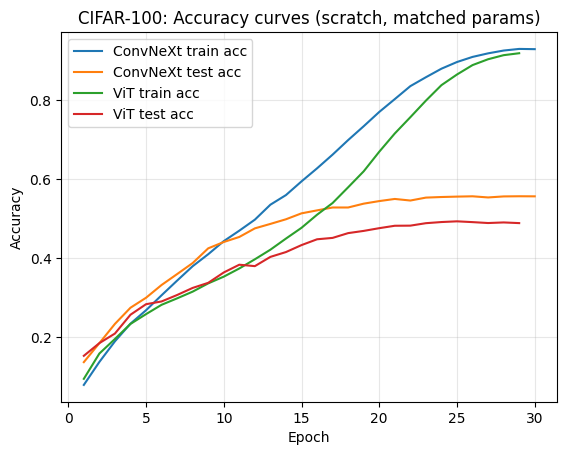

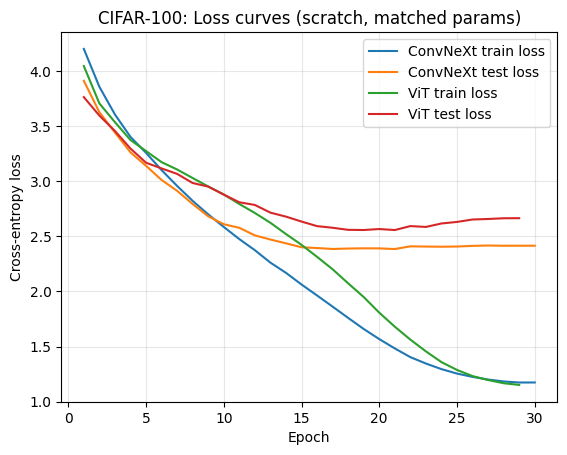

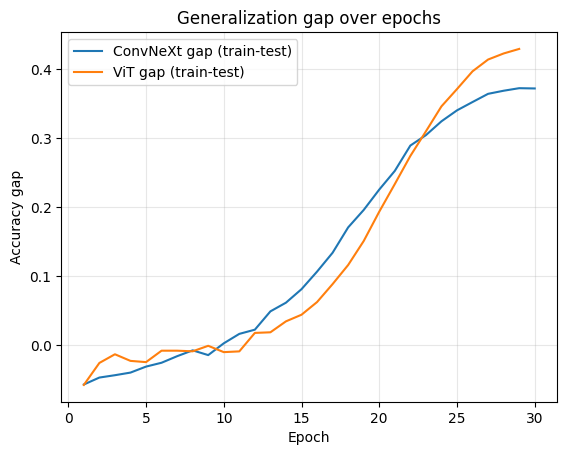

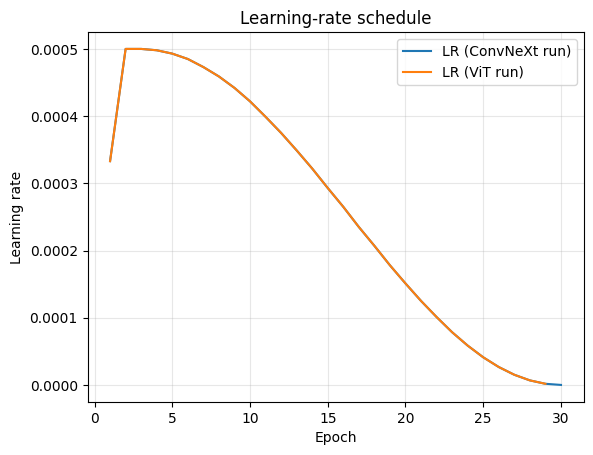

ConvNeXt best test acc: 0.5563 at epoch 29
ViT      best test acc: 0.4929 at epoch 25


In [2]:
# Visualization cell: learning curves (loss/acc) + generalization gap for ConvNeXt vs ViT
# Paste your console output into the strings below (only the epoch lines are enough).

import re
import matplotlib.pyplot as plt

CONVNEXT_LOG = r"""
[ConvNeXt-Tiny (scratch)] Epoch 001/30 | lr 3.33e-04 | train loss 4.2025 acc 0.0792 | test  loss 3.9130 acc 0.1368 | 65.5s
[ConvNeXt-Tiny (scratch)] Epoch 002/30 | lr 5.00e-04 | train loss 3.8587 acc 0.1373 | test  loss 3.6276 acc 0.1848 | 37.0s
[ConvNeXt-Tiny (scratch)] Epoch 003/30 | lr 5.00e-04 | train loss 3.6074 acc 0.1894 | test  loss 3.4437 acc 0.2335 | 36.0s
[ConvNeXt-Tiny (scratch)] Epoch 004/30 | lr 4.98e-04 | train loss 3.4035 acc 0.2341 | test  loss 3.2631 acc 0.2744 | 36.3s
[ConvNeXt-Tiny (scratch)] Epoch 005/30 | lr 4.93e-04 | train loss 3.2591 acc 0.2680 | test  loss 3.1411 acc 0.2996 | 36.6s
[ConvNeXt-Tiny (scratch)] Epoch 006/30 | lr 4.85e-04 | train loss 3.1022 acc 0.3059 | test  loss 3.0123 acc 0.3319 | 36.4s
[ConvNeXt-Tiny (scratch)] Epoch 007/30 | lr 4.73e-04 | train loss 2.9583 acc 0.3430 | test  loss 2.9138 acc 0.3595 | 36.3s
[ConvNeXt-Tiny (scratch)] Epoch 008/30 | lr 4.59e-04 | train loss 2.8226 acc 0.3794 | test  loss 2.7944 acc 0.3874 | 35.3s
[ConvNeXt-Tiny (scratch)] Epoch 009/30 | lr 4.42e-04 | train loss 2.7002 acc 0.4097 | test  loss 2.6824 acc 0.4246 | 34.0s
[ConvNeXt-Tiny (scratch)] Epoch 010/30 | lr 4.22e-04 | train loss 2.5858 acc 0.4428 | test  loss 2.6107 acc 0.4406 | 34.9s
[ConvNeXt-Tiny (scratch)] Epoch 011/30 | lr 3.99e-04 | train loss 2.4755 acc 0.4693 | test  loss 2.5780 acc 0.4534 | 34.7s
[ConvNeXt-Tiny (scratch)] Epoch 012/30 | lr 3.75e-04 | train loss 2.3747 acc 0.4971 | test  loss 2.5090 acc 0.4751 | 34.8s
[ConvNeXt-Tiny (scratch)] Epoch 013/30 | lr 3.49e-04 | train loss 2.2617 acc 0.5350 | test  loss 2.4717 acc 0.4864 | 34.5s
[ConvNeXt-Tiny (scratch)] Epoch 014/30 | lr 3.22e-04 | train loss 2.1692 acc 0.5593 | test  loss 2.4369 acc 0.4981 | 35.5s
[ConvNeXt-Tiny (scratch)] Epoch 015/30 | lr 2.93e-04 | train loss 2.0632 acc 0.5939 | test  loss 2.4013 acc 0.5131 | 35.9s
[ConvNeXt-Tiny (scratch)] Epoch 016/30 | lr 2.65e-04 | train loss 1.9636 acc 0.6269 | test  loss 2.3942 acc 0.5206 | 36.0s
[ConvNeXt-Tiny (scratch)] Epoch 017/30 | lr 2.35e-04 | train loss 1.8622 acc 0.6616 | test  loss 2.3856 acc 0.5279 | 36.5s
[ConvNeXt-Tiny (scratch)] Epoch 018/30 | lr 2.07e-04 | train loss 1.7598 acc 0.6984 | test  loss 2.3899 acc 0.5279 | 35.7s
[ConvNeXt-Tiny (scratch)] Epoch 019/30 | lr 1.78e-04 | train loss 1.6593 acc 0.7334 | test  loss 2.3917 acc 0.5376 | 35.9s
[ConvNeXt-Tiny (scratch)] Epoch 020/30 | lr 1.51e-04 | train loss 1.5674 acc 0.7695 | test  loss 2.3911 acc 0.5441 | 36.6s
[ConvNeXt-Tiny (scratch)] Epoch 021/30 | lr 1.25e-04 | train loss 1.4826 acc 0.8020 | test  loss 2.3853 acc 0.5495 | 37.0s
[ConvNeXt-Tiny (scratch)] Epoch 022/30 | lr 1.01e-04 | train loss 1.4036 acc 0.8348 | test  loss 2.4098 acc 0.5455 | 37.0s
[ConvNeXt-Tiny (scratch)] Epoch 023/30 | lr 7.84e-05 | train loss 1.3456 acc 0.8573 | test  loss 2.4076 acc 0.5529 | 37.0s
[ConvNeXt-Tiny (scratch)] Epoch 024/30 | lr 5.85e-05 | train loss 1.2947 acc 0.8789 | test  loss 2.4063 acc 0.5544 | 36.7s
[ConvNeXt-Tiny (scratch)] Epoch 025/30 | lr 4.11e-05 | train loss 1.2543 acc 0.8958 | test  loss 2.4080 acc 0.5554 | 36.7s
[ConvNeXt-Tiny (scratch)] Epoch 026/30 | lr 2.66e-05 | train loss 1.2242 acc 0.9087 | test  loss 2.4140 acc 0.5562 | 34.6s
[ConvNeXt-Tiny (scratch)] Epoch 027/30 | lr 1.51e-05 | train loss 1.2000 acc 0.9177 | test  loss 2.4171 acc 0.5533 | 34.5s
[ConvNeXt-Tiny (scratch)] Epoch 028/30 | lr 6.74e-06 | train loss 1.1827 acc 0.9248 | test  loss 2.4152 acc 0.5559 | 34.8s
[ConvNeXt-Tiny (scratch)] Epoch 029/30 | lr 1.69e-06 | train loss 1.1731 acc 0.9289 | test  loss 2.4156 acc 0.5563 | 34.9s
[ConvNeXt-Tiny (scratch)] Epoch 030/30 | lr 0.00e+00 | train loss 1.1734 acc 0.9283 | test  loss 2.4151 acc 0.5561 | 34.7s
"""

VIT_LOG = r"""
[ViT (scratch, matched params)] Epoch 001/30 | lr 3.33e-04 | train loss 4.0471 acc 0.0946 | test  loss 3.7648 acc 0.1528 | 72.2s
[ViT (scratch, matched params)] Epoch 002/30 | lr 5.00e-04 | train loss 3.7077 acc 0.1586 | test  loss 3.5970 acc 0.1849 | 72.3s
[ViT (scratch, matched params)] Epoch 003/30 | lr 5.00e-04 | train loss 3.5377 acc 0.1954 | test  loss 3.4575 acc 0.2091 | 72.1s
[ViT (scratch, matched params)] Epoch 004/30 | lr 4.98e-04 | train loss 3.3752 acc 0.2334 | test  loss 3.2977 acc 0.2567 | 72.1s
[ViT (scratch, matched params)] Epoch 005/30 | lr 4.93e-04 | train loss 3.2752 acc 0.2582 | test  loss 3.1693 acc 0.2833 | 72.3s
[ViT (scratch, matched params)] Epoch 006/30 | lr 4.85e-04 | train loss 3.1742 acc 0.2818 | test  loss 3.1172 acc 0.2903 | 72.1s
[ViT (scratch, matched params)] Epoch 007/30 | lr 4.73e-04 | train loss 3.1075 acc 0.2981 | test  loss 3.0677 acc 0.3066 | 72.3s
[ViT (scratch, matched params)] Epoch 008/30 | lr 4.59e-04 | train loss 3.0300 acc 0.3151 | test  loss 2.9848 acc 0.3245 | 72.0s
[ViT (scratch, matched params)] Epoch 009/30 | lr 4.42e-04 | train loss 2.9536 acc 0.3360 | test  loss 2.9522 acc 0.3374 | 72.1s
[ViT (scratch, matched params)] Epoch 010/30 | lr 4.22e-04 | train loss 2.8805 acc 0.3530 | test  loss 2.8796 acc 0.3636 | 72.0s
[ViT (scratch, matched params)] Epoch 011/30 | lr 3.99e-04 | train loss 2.7942 acc 0.3737 | test  loss 2.8099 acc 0.3832 | 72.1s
[ViT (scratch, matched params)] Epoch 012/30 | lr 3.75e-04 | train loss 2.7127 acc 0.3969 | test  loss 2.7855 acc 0.3796 | 72.1s
[ViT (scratch, matched params)] Epoch 013/30 | lr 3.49e-04 | train loss 2.6235 acc 0.4212 | test  loss 2.7158 acc 0.4030 | 72.2s
[ViT (scratch, matched params)] Epoch 014/30 | lr 3.22e-04 | train loss 2.5215 acc 0.4493 | test  loss 2.6795 acc 0.4152 | 72.1s
[ViT (scratch, matched params)] Epoch 015/30 | lr 2.93e-04 | train loss 2.4235 acc 0.4765 | test  loss 2.6348 acc 0.4328 | 71.9s
[ViT (scratch, matched params)] Epoch 016/30 | lr 2.65e-04 | train loss 2.3143 acc 0.5096 | test  loss 2.5932 acc 0.4475 | 72.1s
[ViT (scratch, matched params)] Epoch 017/30 | lr 2.35e-04 | train loss 2.2015 acc 0.5392 | test  loss 2.5785 acc 0.4510 | 72.1s
[ViT (scratch, matched params)] Epoch 018/30 | lr 2.07e-04 | train loss 2.0739 acc 0.5790 | test  loss 2.5595 acc 0.4631 | 72.2s
[ViT (scratch, matched params)] Epoch 019/30 | lr 1.78e-04 | train loss 1.9494 acc 0.6194 | test  loss 2.5580 acc 0.4687 | 72.2s
[ViT (scratch, matched params)] Epoch 020/30 | lr 1.51e-04 | train loss 1.8073 acc 0.6689 | test  loss 2.5668 acc 0.4756 | 72.3s
[ViT (scratch, matched params)] Epoch 021/30 | lr 1.25e-04 | train loss 1.6801 acc 0.7151 | test  loss 2.5577 acc 0.4817 | 72.1s
[ViT (scratch, matched params)] Epoch 022/30 | lr 1.01e-04 | train loss 1.5628 acc 0.7562 | test  loss 2.5936 acc 0.4820 | 72.1s
[ViT (scratch, matched params)] Epoch 023/30 | lr 7.84e-05 | train loss 1.4559 acc 0.7981 | test  loss 2.5859 acc 0.4882 | 72.2s
[ViT (scratch, matched params)] Epoch 024/30 | lr 5.85e-05 | train loss 1.3584 acc 0.8373 | test  loss 2.6172 acc 0.4911 | 72.0s
[ViT (scratch, matched params)] Epoch 025/30 | lr 4.11e-05 | train loss 1.2873 acc 0.8642 | test  loss 2.6314 acc 0.4929 | 72.0s
[ViT (scratch, matched params)] Epoch 026/30 | lr 2.66e-05 | train loss 1.2315 acc 0.8880 | test  loss 2.6534 acc 0.4909 | 72.1s
[ViT (scratch, matched params)] Epoch 027/30 | lr 1.51e-05 | train loss 1.1957 acc 0.9028 | test  loss 2.6581 acc 0.4886 | 72.2s
[ViT (scratch, matched params)] Epoch 028/30 | lr 6.74e-06 | train loss 1.1666 acc 0.9131 | test  loss 2.6647 acc 0.4901 | 72.1s
[ViT (scratch, matched params)] Epoch 029/30 | lr 1.69e-06 | train loss 1.1512 acc 0.9180 | test  loss 2.6654 acc 0.4884 | 72.1s
"""

def parse_log(text):
    pat = re.compile(
        r"Epoch\s+(\d+)/(\d+)\s+\|\s+lr\s+([0-9.eE+-]+)\s+\|\s+train loss\s+([0-9.]+)\s+acc\s+([0-9.]+)\s+\|\s+test\s+loss\s+([0-9.]+)\s+acc\s+([0-9.]+)"
    )
    rows = []
    for line in text.strip().splitlines():
        m = pat.search(line)
        if m:
            ep = int(m.group(1))
            lr = float(m.group(3))
            tr_loss = float(m.group(4))
            tr_acc  = float(m.group(5))
            te_loss = float(m.group(6))
            te_acc  = float(m.group(7))
            rows.append((ep, lr, tr_loss, tr_acc, te_loss, te_acc))
    rows.sort(key=lambda x: x[0])
    return rows

cnx = parse_log(CONVNEXT_LOG)
vit = parse_log(VIT_LOG)

def unpack(rows):
    e = [r[0] for r in rows]
    lr = [r[1] for r in rows]
    tr_loss = [r[2] for r in rows]
    tr_acc  = [r[3] for r in rows]
    te_loss = [r[4] for r in rows]
    te_acc  = [r[5] for r in rows]
    return e, lr, tr_loss, tr_acc, te_loss, te_acc

e1, lr1, trl1, tra1, tel1, tea1 = unpack(cnx)
e2, lr2, trl2, tra2, tel2, tea2 = unpack(vit)

# ---- Plot 1: Accuracy curves ----
plt.figure()
plt.plot(e1, tra1, label="ConvNeXt train acc")
plt.plot(e1, tea1, label="ConvNeXt test acc")
plt.plot(e2, tra2, label="ViT train acc")
plt.plot(e2, tea2, label="ViT test acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CIFAR-100: Accuracy curves (scratch, matched params)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ---- Plot 2: Loss curves ----
plt.figure()
plt.plot(e1, trl1, label="ConvNeXt train loss")
plt.plot(e1, tel1, label="ConvNeXt test loss")
plt.plot(e2, trl2, label="ViT train loss")
plt.plot(e2, tel2, label="ViT test loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy loss")
plt.title("CIFAR-100: Loss curves (scratch, matched params)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ---- Plot 3: Generalization gap (train acc - test acc) ----
gap1 = [a-b for a,b in zip(tra1, tea1)]
gap2 = [a-b for a,b in zip(tra2, tea2)]

plt.figure()
plt.plot(e1, gap1, label="ConvNeXt gap (train-test)")
plt.plot(e2, gap2, label="ViT gap (train-test)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy gap")
plt.title("Generalization gap over epochs")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ---- Optional: learning-rate schedule ----
plt.figure()
plt.plot(e1, lr1, label="LR (ConvNeXt run)")
plt.plot(e2, lr2, label="LR (ViT run)")
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.title("Learning-rate schedule")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print quick summary
print(f"ConvNeXt best test acc: {max(tea1):.4f} at epoch {e1[tea1.index(max(tea1))]}")
print(f"ViT      best test acc: {max(tea2):.4f} at epoch {e2[tea2.index(max(tea2))]}")


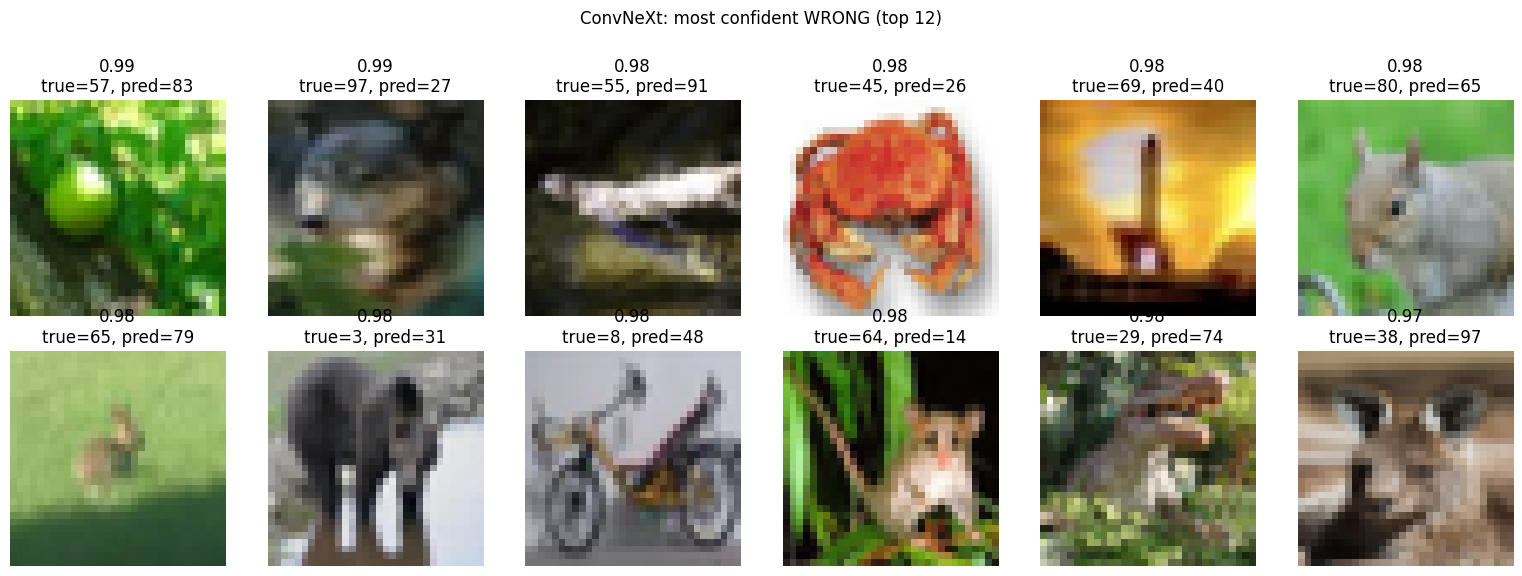

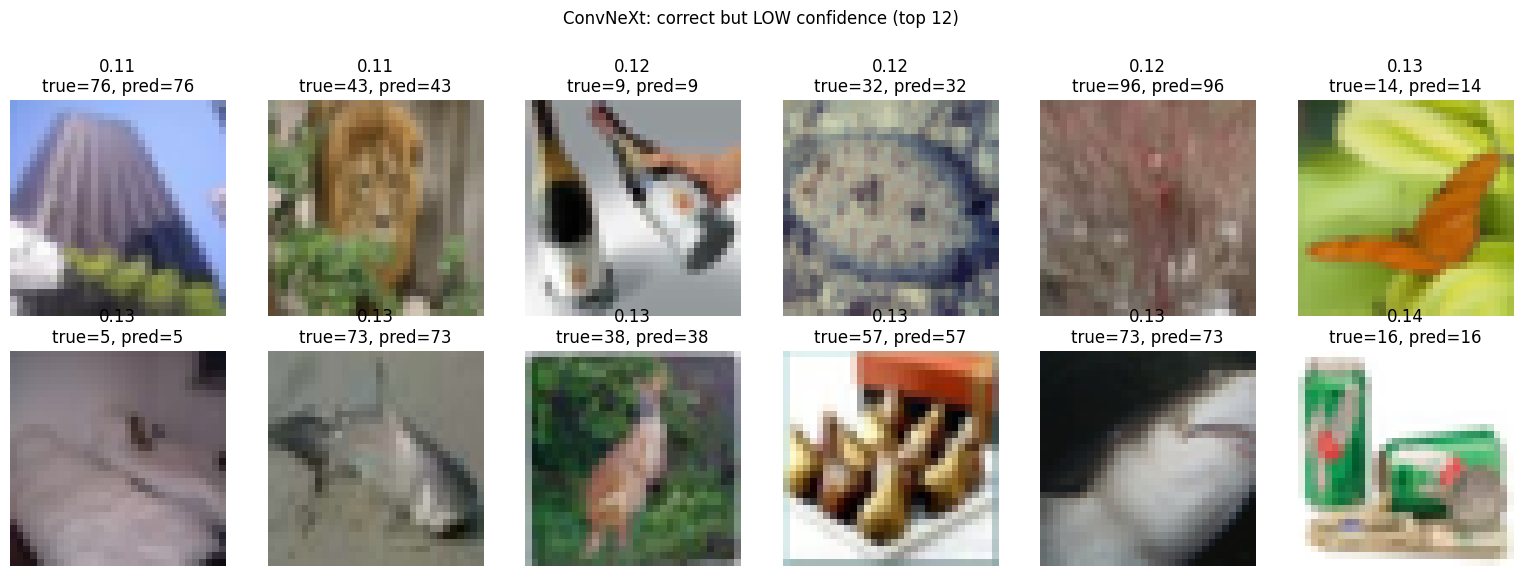

In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
convnext.to(DEVICE).eval()

MEAN = torch.tensor((0.5071, 0.4867, 0.4408)).view(3,1,1)
STD  = torch.tensor((0.2675, 0.2565, 0.2761)).view(3,1,1)
def denorm(x): return (x*STD + MEAN).clamp(0,1)

@torch.no_grad()
def collect_extremes(model, loader, topk_wrong=12, topk_lowconf_correct=12):
    wrong, lowc = [], []
    for xb, yb in loader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True)
        probs = F.softmax(model(xb), dim=1)
        conf, pred = probs.max(dim=1)

        mw = pred.ne(yb)
        for c, x, yt, yp in zip(conf[mw].cpu(), xb[mw].cpu(), yb[mw].cpu(), pred[mw].cpu()):
            wrong.append((float(c), x, int(yt), int(yp)))

        mc = pred.eq(yb)
        for c, x, yt, yp in zip(conf[mc].cpu(), xb[mc].cpu(), yb[mc].cpu(), pred[mc].cpu()):
            lowc.append((float(c), x, int(yt), int(yp)))

    wrong.sort(key=lambda t: t[0], reverse=True)
    lowc.sort(key=lambda t: t[0])
    return wrong[:topk_wrong], lowc[:topk_lowconf_correct]

def show_grid(items, title, ncols=6):
    if not items:
        print(title, "(none)")
        return
    n = len(items)
    nrows = int(np.ceil(n / ncols))
    plt.figure(figsize=(2.6*ncols, 2.8*nrows))
    for i,(conf,img,yt,yp) in enumerate(items):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(denorm(img).permute(1,2,0).numpy())
        plt.title(f"{conf:.2f}\ntrue={yt}, pred={yp}")
        plt.axis("off")
    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()

wrong, lowc = collect_extremes(convnext, test_loader)
show_grid(wrong, "ConvNeXt: most confident WRONG (top 12)")
show_grid(lowc,  "ConvNeXt: correct but LOW confidence (top 12)")



In [ ]:
# One-cell: Train ViT (scratch, matched params) on CIFAR-100 + SAVE best checkpoint
# Uses the SAME config you matched: embed_dim=432, heads=6, depth=12, patch=4

!pip -q install timm

import os, math, time, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from timm.models.vision_transformer import VisionTransformer

# ----------------- Config -----------------
SEED = 42
EPOCHS = 30
BATCH_SIZE = 128
NUM_WORKERS = 2

LR = 5e-4
WEIGHT_DECAY = 0.05
WARMUP_EPOCHS = 3
LABEL_SMOOTHING = 0.1

# Matched-ViT config (from your run)
VIT_EMBED = 432
VIT_HEADS = 6
VIT_DEPTH = 12
VIT_PATCH = 4
VIT_MLP_RATIO = 4.0
VIT_DROP_PATH = 0.1

CKPT_PATH = "./vit_best_cifar100_e432_h6_d12_p4.pth"

# ----------------- Repro/Device -----------------
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ----------------- Data -----------------
CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD  = (0.2675, 0.2565, 0.2761)

train_tfms = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(CIFAR100_MEAN, CIFAR100_STD),
])
test_tfms = T.Compose([
    T.ToTensor(),
    T.Normalize(CIFAR100_MEAN, CIFAR100_STD),
])

train_ds = torchvision.datasets.CIFAR100("./data", train=True, download=True, transform=train_tfms)
test_ds  = torchvision.datasets.CIFAR100("./data", train=False, download=True, transform=test_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

# ----------------- Model -----------------
vit_model = VisionTransformer(
    img_size=32, patch_size=VIT_PATCH, in_chans=3,
    num_classes=100, embed_dim=VIT_EMBED,
    depth=VIT_DEPTH, num_heads=VIT_HEADS, mlp_ratio=VIT_MLP_RATIO,
    qkv_bias=True, drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=VIT_DROP_PATH
).to(device)

params_m = sum(p.numel() for p in vit_model.parameters()) / 1e6
print(f"ViT params (M): {params_m:.3f}")

# ----------------- Optim / Sched / Loss -----------------
optimizer = optim.AdamW(vit_model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

def lr_lambda(epoch):
    # linear warmup then cosine
    if epoch < WARMUP_EPOCHS:
        return (epoch + 1) / max(1, WARMUP_EPOCHS)
    t = (epoch - WARMUP_EPOCHS) / max(1, (EPOCHS - WARMUP_EPOCHS))
    return 0.5 * (1.0 + math.cos(math.pi * t))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
loss_fn = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

scaler = torch.amp.GradScaler("cuda", enabled=(device.type == "cuda"))

@torch.no_grad()
def evaluate():
    vit_model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in test_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = vit_model(x)
        loss = loss_fn(logits, y)
        loss_sum += float(loss.item()) * x.size(0)
        correct += int((logits.argmax(1) == y).sum().item())
        total += int(x.size(0))
    return loss_sum / total, correct / total

def train_one_epoch():
    vit_model.train()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in train_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        if device.type == "cuda":
            with torch.amp.autocast("cuda"):
                logits = vit_model(x)
                loss = loss_fn(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = vit_model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()

        loss_sum += float(loss.item()) * x.size(0)
        correct += int((logits.argmax(1) == y).sum().item())
        total += int(x.size(0))
    return loss_sum / total, correct / total

# ----------------- Train + Save best -----------------
os.makedirs(os.path.dirname(CKPT_PATH) or ".", exist_ok=True)

best_acc = -1.0
history = []  # (epoch, lr, train_loss, train_acc, test_loss, test_acc)

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    tr_loss, tr_acc = train_one_epoch()
    te_loss, te_acc = evaluate()
    lr_now = optimizer.param_groups[0]["lr"]
    scheduler.step()

    history.append((epoch, lr_now, tr_loss, tr_acc, te_loss, te_acc))
    print(f"[ViT scratch] Epoch {epoch:03d}/{EPOCHS} | lr {lr_now:.2e} | "
          f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | test loss {te_loss:.4f} acc {te_acc:.4f} | {time.time()-t0:.1f}s")

    if te_acc > best_acc:
        best_acc = te_acc
        torch.save(
            {"epoch": epoch,
             "test_acc": te_acc,
             "model_state": vit_model.state_dict(),
             "config": dict(embed_dim=VIT_EMBED, heads=VIT_HEADS, depth=VIT_DEPTH, patch=VIT_PATCH)},
            CKPT_PATH
        )

print("\nBest test acc:", best_acc)
print("Saved best checkpoint:", CKPT_PATH)

# Keep vit_model and history in memory for visualizations


Device: cuda
ViT params (M): 27.035
[ViT scratch] Epoch 001/30 | lr 1.67e-04 | train loss 4.0487 acc 0.0961 | test loss 3.7821 acc 0.1453 | 70.4s
[ViT scratch] Epoch 002/30 | lr 3.33e-04 | train loss 3.6650 acc 0.1671 | test loss 3.5278 acc 0.1930 | 72.3s
[ViT scratch] Epoch 003/30 | lr 5.00e-04 | train loss 3.4977 acc 0.2052 | test loss 3.3699 acc 0.2303 | 72.2s
[ViT scratch] Epoch 004/30 | lr 5.00e-04 | train loss 3.3402 acc 0.2441 | test loss 3.2198 acc 0.2694 | 72.0s
[ViT scratch] Epoch 005/30 | lr 4.98e-04 | train loss 3.2283 acc 0.2676 | test loss 3.1674 acc 0.2816 | 72.2s
[ViT scratch] Epoch 006/30 | lr 4.93e-04 | train loss 3.1398 acc 0.2879 | test loss 3.0760 acc 0.3098 | 72.1s
[ViT scratch] Epoch 007/30 | lr 4.85e-04 | train loss 3.0693 acc 0.3041 | test loss 3.0174 acc 0.3187 | 72.1s
[ViT scratch] Epoch 008/30 | lr 4.73e-04 | train loss 2.9858 acc 0.3238 | test loss 2.9480 acc 0.3427 | 72.1s
[ViT scratch] Epoch 009/30 | lr 4.59e-04 | train loss 2.9201 acc 0.3412 | test loss 